In [32]:
import os
import gemmi
import reciprocalspaceship as rs

import numpy as np
from sklearn.decomposition import NMF
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt

import masks
import models

from importlib import reload
reload(models)

<module 'models' from '/Users/tjlane/opt/mmcpd-scripts/models.py'>

In [33]:
# base_path = '/Users/tjlane/Desktop/PL-workshop/nmf/intensity_polder/ttd_chainA/'
# MASK = masks.TT_chainA_region_only
# MASK_NAME = 'TT_region'

# base_path = '/Users/tjlane/Desktop/PL-workshop/nmf/polder/ttd_chainA/'
# MASK = masks.TT_chainA_region_only
# MASK_NAME = 'TT_region_extr'

# base_path = '/Users/tjlane/Desktop/PL-workshop/nmf/intensity_polder/ttd_chainB/'
# MASK = masks.TT_chainB_region_only
# MASK_NAME = 'TT_region-B'

# base_path = '/Users/tjlane/Desktop/PL-workshop/nmf/polder/ttd_chainB/'
# MASK = masks.TT_chainB_region_only
# MASK_NAME = 'TT_region_extr-B'

# base_path = '/Users/tjlane/Desktop/PL-workshop/nmf/polder/fda_chainA/'
# MASK = masks.FDA_chainA_region_only
# MASK_NAME = 'FAD_region_extr'

# base_path = '/Users/tjlane/Desktop/PL-workshop/nmf/polder/fda_chainB/'
# MASK = masks.FDA_chainB_region_only
# MASK_NAME = 'FAD_region_extr-B'

base_path = '/Users/tjlane/Desktop/PL-workshop/nmf/polder/fda_both/'
MASK = masks.FDA_both_chains
MASK_NAME = 'FAD_both_chains'

In [34]:
timepoints = {
         0.0 : 'superdark_deposit_polder_map_coeffs.mtz',
         3.0 : '3ps_deposit_polder_map_coeffs.mtz',
       300.0 : '300ps_deposit_polder_map_coeffs.mtz',
      1000.0 : '1ns_deposit_polder_map_coeffs.mtz',
      3000.0 : '3ns_deposit_polder_map_coeffs.mtz',
     10000.0 : '10ns_deposit_polder_map_coeffs.mtz',
     30000.0 : '30ns_deposit_polder_map_coeffs.mtz',
   1000000.0 : '1us_deposit_polder_map_coeffs.mtz',
  10000000.0 : '10us_deposit_polder_map_coeffs.mtz',
  30000000.0 : '30us_deposit_polder_map_coeffs.mtz',
 100000000.0 : '100us_deposit_polder_map_coeffs.mtz',
}

for k in timepoints.keys():
    timepoints[k] = base_path + timepoints[k]
    if not os.path.exists(timepoints[k]):
        print('cant find', k)

In [35]:
# load all Fs and sigFs into one big rs table
tps = sorted(timepoints.keys())
maps = []

for tp in tps:

    ds = rs.read_mtz(timepoints[tp]) 
    ds.compute_dHKL(inplace=True)

    gemmi_mtz = ds.to_gemmi()
    #grid = gemmi_mtz.transform_f_phi_to_map('2FOFCWT', 'PH2FOFCWT', exact_size=(180, 300, 432))
    grid = gemmi_mtz.transform_f_phi_to_map('mFo-DFc_polder', 'PHImFo-DFc_polder', exact_size=(180, 300, 432))

    map = MASK(grid)
    map = np.array(map)
    
    MAP_SHAPE = map.shape
    maps.append(map.flatten())

    fraction_of_zeros = np.sum(map == 0) / float(np.product(map.shape))
    print( MAP_SHAPE, np.min(ds['dHKL']), np.max(ds['dHKL']), fraction_of_zeros)


maps = np.array(maps)
#assert maps.min() > -1e-32, maps.min()
print(maps.shape)

(180, 300, 432) 2.107942 32.45577 0.9950617283950617
(180, 300, 432) 2.163017 31.289146 0.9950617283950617
(180, 300, 432) 2.350099 30.97964 0.9950617283950617
(180, 300, 432) 2.2747512 31.289146 0.9950617283950617
(180, 300, 432) 2.3459172 31.289146 0.9950617283950617
(180, 300, 432) 2.3633437 31.289146 0.9950617283950617
(180, 300, 432) 2.390934 31.289146 0.9950617283950617
(180, 300, 432) 2.2414005 31.289146 0.9950617283950617
(180, 300, 432) 2.1829526 31.289146 0.9950617283950617
(180, 300, 432) 2.2473514 31.289146 0.9950617283950617
(180, 300, 432) 2.5000052 30.97964 0.9950617283950617
(11, 23328000)


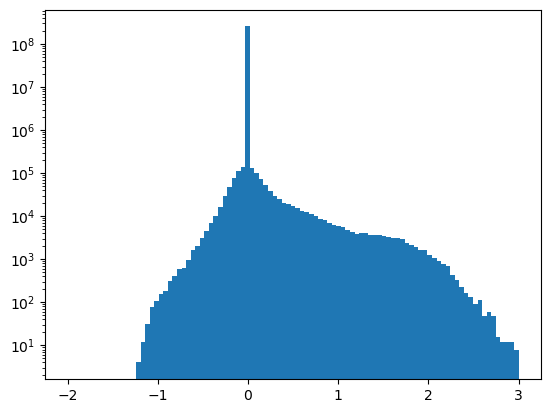

In [36]:
plt.figure()
plt.hist(maps.flatten(), bins=np.linspace(-2, 3, 100))
plt.yscale('log')
plt.show()

In [37]:
maps[maps < 0] = 0.0

In [38]:
N_COMPONENTS = 4

model = NMF(n_components=N_COMPONENTS, init='random', random_state=0)
W = model.fit_transform(np.abs(maps))
H = model.components_

/opt/homebrew/Caskroom/miniforge/base/envs/rs/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [39]:
times = sorted(timepoints.keys())
populations = W / W.sum(axis=1)[:,None]

# we need to re-order the states so they appear in the order they are populated

#populations = populations[:, np.array([1,2,0])] # TTD 3 components, FAD 3 components
populations = populations[ :, np.array([3,2,1,0])]

lk_model = models.LinearKinetic(n_states=N_COMPONENTS, times=times, populations=populations)
k_opt = lk_model.fit(k0=[1e-4,] * (N_COMPONENTS-1))

print(k_opt)
print('timescales (ns):', 1e-3 / k_opt)

residual: 4.781365929943778
[3.54182953e-03 2.48538585e-04 6.33642763e-07]
timescales (ns): [2.82339958e-01 4.02352014e+00 1.57817631e+03]


/opt/homebrew/Caskroom/miniforge/base/envs/rs/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


87.24468890532822


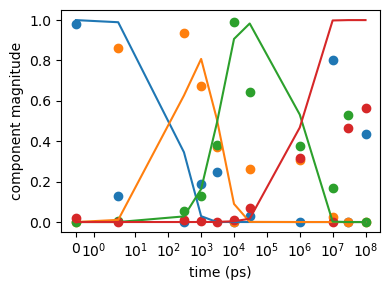

In [40]:
print(model.reconstruction_err_)

plt.figure(figsize=(4,3))

plt.plot(times, populations, 'o')
plt.gca().set_prop_cycle(None)
plt.plot(times, lk_model.estimate(times, k_opt))

plt.xlabel('time (ps)')
plt.xscale('symlog')
plt.ylabel('component magnitude')

plt.tight_layout()
plt.savefig(f'/Users/tjlane/Desktop/PL-workshop/nmf/plots/populations_{MASK_NAME}.png')
plt.savefig(f'/Users/tjlane/Desktop/PL-workshop/nmf/plots/populations_{MASK_NAME}.pdf')
plt.show()

In [42]:
output_path = '/Users/tjlane/Desktop/PL-workshop/nmf/components/'

for i in range(N_COMPONENTS):
    component_grid = gemmi.FloatGrid(H[i,:].reshape(MAP_SHAPE))
    masks.grid_to_PL_map(
        component_grid, 
        output_path + f'nmf_mask{MASK_NAME}_comp{i}.ccp4'
    )